In [4]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# These are the column names:
"""
Unique: 
tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,minutes

prefixed with winner/loser:
winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points

prefixed with w/l:
w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced
"""

'\nUnique: \ntourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,minutes\n\nprefixed with winner/loser:\nwinner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points\n\nprefixed with w/l:\nw_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced\n'

In [5]:
BASE_DIR = Path.cwd()

def create_match_table(year):
    dataframes = []
    
    sources = [
        ("matches", "atp_matches", f"atp_matches_{year}.csv"),
        ("challengers", "atp_qual_chall", f"atp_matches_qual_chall_{year}.csv"),
        ("futures", "atp_futures", f"atp_matches_futures_{year}.csv")
    ]
    
    for tourney_type, folder, filename in sources:
        path = BASE_DIR / "atp_sources" / folder / filename
        try:
            df = pd.read_csv(path)
            df["tourney_type"] = tourney_type
            dataframes.append(df)
        except FileNotFoundError:
            print(f"Warning: {filename} not found, skipping.")
        except pd.errors.EmptyDataError:
            print(f"Warning: {filename} is empty, skipping.")
        except Exception as e:
            print(f"Error reading {filename}: {e}, skipping.")

    if not dataframes:
        raise ValueError(f"No datasets found for year {year}.")
    

    # Concatenate available tables
    big_match_table_df = pd.concat(dataframes, ignore_index=True)

    # Post processing to round age columns safely
    big_match_table_df["winner_age"] = round(big_match_table_df["winner_age"],0)
    big_match_table_df["loser_age"] = round(big_match_table_df["loser_age"],0)

    big_match_table_df["score"] = big_match_table_df["score"].replace("6-36-3","6-3")

    # rename round to avoid calling round method/function
    big_match_table_df = big_match_table_df.rename(columns={"round":"tourney_round"})

    # create all columns as nan columns and then cast as object type to prevent warnings
    all_rounds_cols = ["round_1", "round_2", "round_3", "round_4", "round_5"]
    big_match_table_df[all_rounds_cols] = np.nan
    big_match_table_df[all_rounds_cols] = big_match_table_df[all_rounds_cols].astype("object")

    MAX_SETS = 5
    
    # split scores into round columns
    split_rounds = big_match_table_df['score'].fillna("").str.split(" ", n=MAX_SETS-1, expand=True)
    
    for i, col in enumerate(all_rounds_cols):
        big_match_table_df[col] = split_rounds[i].replace("", pd.NA)  # convert empty strings to NA

    REPLACED_ROUND_VALUES = ['RET', 'RE', 'W/O', 'DEF', 'Def.', "Ret'd", 'default', 
                         'walkover','played','and','abandoned','unfinished','&nbsp;',
                         '>','Mar-00','May-00','UNK','Walkover','ABD','Played','Default','and abandoned']
    
    for col in all_rounds_cols:
        big_match_table_df[col] = big_match_table_df[col].replace(REPLACED_ROUND_VALUES, pd.NA)
        # remove the trailing RET values
        big_match_table_df[col] = big_match_table_df[col].str.split(" ").str[0]

    # clean round 2 and 3
    big_match_table_df['round_2'] = big_match_table_df['round_2'].str.replace(r"[?]", "0", regex=True)
    big_match_table_df['round_3'] = big_match_table_df['round_3'].str.replace(r"[\[\]]", "", regex=True)

    big_match_table_df['winner_outcome'] = 1
    big_match_table_df['loser_outcome'] = 0

    return big_match_table_df

# ( First script; create a matches table )

# create folder if it does not exist
os.makedirs("atp_transformed", exist_ok=True)

# call the function for each year we want to look at (we can extend this if needed)
used_dfs = [create_match_table(year) for year in range(2000, 2025)]

# concatenate all years after 1999 up to the given year into a single DataFrame
df_post_1999 = pd.concat(used_dfs, ignore_index=True)

# ddf = calculate_elo(df_post_1999,K=32)
# all_player_elo = pd.concat([ddf["winner_elo_pre_match"], ddf["loser_elo_pre_match"]], ignore_index=True)

# plt.hist(all_player_elo,bins=300)

# now check if a player has their career cut short due to how splitting was handled by first calling the function for the years that were left out
unused_dfs = [create_match_table(year) for year in range(1968, 2000)]

# Concatenate all years into a single DataFrame
df_pre_2000 = pd.concat(unused_dfs, ignore_index=True)

# get all ids from before 2000
ids_pre_2000 = df_pre_2000["winner_id"] + df_pre_2000["loser_id"]
ids_pre_2000 = ids_pre_2000.drop_duplicates(keep='last')
list_of_ids_pre_2000 = ids_pre_2000.to_list()

# include pre-2000 matches for players who started before the year 2000
df_early = df_pre_2000[
    df_pre_2000["winner_id"].isin(list_of_ids_pre_2000) |
    df_pre_2000["loser_id"].isin(list_of_ids_pre_2000)
]

# combine datasets
match_table_df = pd.concat([df_early, df_post_1999], ignore_index=True)

# format date to have proper date format
match_table_df["tourney_date"] = pd.to_datetime(match_table_df["tourney_date"].astype(str), format="%Y%m%d")

# sort by date
match_table_df = match_table_df.sort_values("tourney_date")

# create unique match ids
match_table_df['tourney_match_id'] = match_table_df['tourney_id'].astype(str) + ':' + match_table_df['match_num'].astype(str)
match_table_df['winner_tourney_match_id'] = match_table_df['winner_id'].astype(str) + ':' + match_table_df['tourney_id'].astype(str) + ':' + match_table_df['match_num'].astype(str)
match_table_df['loser_tourney_match_id'] = match_table_df['loser_id'].astype(str) + ':' + match_table_df['tourney_id'].astype(str) + ':' + match_table_df['match_num'].astype(str)

In [6]:

def calculate_elo(match_df, initial_elo=1500, K=32):
    """
    Calculate Elo ratings and return a match-level DataFrame
    with both pre- and post-match Elos.
    """
    player_elos = {}

    # Initialize new columns
    match_df['winner_elo_pre_match'] = np.nan
    match_df['loser_elo_pre_match'] = np.nan
    match_df['winner_elo_post_match'] = np.nan
    match_df['loser_elo_post_match'] = np.nan

    # Ensure chronological order
    match_df = match_df.sort_values(["tourney_date", "match_num"])

    for idx, row in match_df.iterrows():

        winner = row['winner_id']
        loser = row['loser_id']

        # Current Elo (or initialize)
        R_w = player_elos.get(winner, initial_elo)
        R_l = player_elos.get(loser, initial_elo)

        # Store pre-match Elos
        match_df.at[idx, 'winner_elo_pre_match'] = R_w
        match_df.at[idx, 'loser_elo_pre_match'] = R_l

        # Expected score
        E_w = 1 / (1 + 10 ** ((R_l - R_w) / 400))

        # Actual scores (winner=1, loser=0)
        S_w = 1
        S_l = 0

        # Update Elo
        R_w_new = R_w + K * (S_w - E_w)
        R_l_new = R_l + K * (S_l - (1 - E_w))

        # Store post-match Elos
        match_df.at[idx, 'winner_elo_post_match'] = R_w_new
        match_df.at[idx, 'loser_elo_post_match'] = R_l_new

        # Save updated values back to dictionary
        player_elos[winner] = R_w_new
        player_elos[loser] = R_l_new

    return match_df


#  # # --------------------------------------------------------------------- ( ELO Calculation )-----------------------------------------------------------------------------------------

# calculate the elo
match_table_incl_elo_df = calculate_elo(match_table_df,K=32)

In [7]:
match_table_incl_elo_df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,round_5,winner_outcome,loser_outcome,tourney_match_id,winner_tourney_match_id,loser_tourney_match_id,winner_elo_pre_match,loser_elo_pre_match,winner_elo_post_match,loser_elo_post_match
656,1968-T102,Calcutta,NaN,NaN,A,1967-12-28,102,100051,NaN,NaN,...,None,1,0,1968-T102:102,100051:1968-T102:102,211821:1968-T102:102,1500.000000,1500.000000,1516.000000,1484.000000
572,1968-243,Perth,NaN,NaN,A,1968-01-01,102,100079,NaN,NaN,...,None,1,0,1968-243:102,100079:1968-243:102,204611:1968-243:102,1500.000000,1500.000000,1516.000000,1484.000000
573,1968-243,Perth,NaN,NaN,A,1968-01-01,104,204611,NaN,NaN,...,None,1,0,1968-243:104,204611:1968-243:104,110041:1968-243:104,1484.000000,1500.000000,1500.736307,1483.263693
574,1968-243,Perth,NaN,NaN,A,1968-01-01,108,204611,NaN,NaN,...,None,1,0,1968-243:108,204611:1968-243:108,108430:1968-243:108,1500.736307,1500.000000,1516.702399,1484.033908
575,1968-243,Perth,NaN,NaN,A,1968-01-01,109,100079,NaN,NaN,...,None,1,0,1968-243:109,100079:1968-243:109,212421:1968-243:109,1516.000000,1500.000000,1531.263693,1484.736307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617923,2024-7696,Next Gen Finals,Hard,8.0,F,2024-12-18,396,210530,5.0,NaN,...,None,1,0,2024-7696:396,210530:2024-7696:396,209950:2024-7696:396,2125.765496,2363.095512,2151.261896,2337.599112
617922,2024-7696,Next Gen Finals,Hard,8.0,F,2024-12-18,397,209950,1.0,NaN,...,None,1,0,2024-7696:397,209950:2024-7696:397,210150:2024-7696:397,2337.599112,2255.654700,2349.893883,2243.359929
617921,2024-7696,Next Gen Finals,Hard,8.0,F,2024-12-18,398,210530,5.0,NaN,...,4-1,1,0,2024-7696:398,210530:2024-7696:398,210506:2024-7696:398,2151.261896,2308.602451,2174.049882,2285.814465
617920,2024-7696,Next Gen Finals,Hard,8.0,F,2024-12-18,399,211663,8.0,NaN,...,None,1,0,2024-7696:399,211663:2024-7696:399,209414:2024-7696:399,2135.493924,2056.300576,2147.908810,2043.885690


In [8]:
#  ( call function; encode the columns and get the difference, avg diff and avg tiebreak score )

all_rounds_cols = ["round_1", "round_2", "round_3", "round_4", "round_5"]

for col in all_rounds_cols:
    # Split by '-' into winner and loser scores
    split_scores = match_table_incl_elo_df[col].str.split("-", n=1, expand=True)
    
    # Assign winner and loser columns
    match_table_incl_elo_df[f"{col}_w"] = split_scores[0]
    match_table_incl_elo_df[f"{col}_l"] = split_scores[1]

all_round_scores = []

for mt in match_table_incl_elo_df.itertuples():
    match_row_scores = []
    
    for round_col in all_rounds_cols:
        # access winner and loser scores dynamically
        w_score = getattr(mt, f"{round_col}_w")
        l_score = getattr(mt, f"{round_col}_l")
        
        # initialize tiebreak values as NA
        w_tb = pd.NA
        l_tb = pd.NA

        # skip if winner score is NA
        if not pd.isna(w_score):
            w_score_str = str(w_score)
            l_score_str = str(l_score) if not pd.isna(l_score) else pd.NA

            # tiebreak number in winner
            if '(' in w_score_str:
                clean_w_score = w_score_str.split('(')[0]
                clean_w_tb = w_score_str.split('(')[1].strip(')')
                w_score = clean_w_score
                w_tb = clean_w_tb
                l_tb = str(int(clean_w_tb) - 2)  # loser tiebreak score
            # tiebreak number in loser
            elif '(' in l_score_str:
                clean_l_score = l_score_str.split('(')[0]
                clean_l_tb = l_score_str.split('(')[1].strip(')')
                l_score = clean_l_score
                l_tb = clean_l_tb
                w_tb = str(int(clean_l_tb) + 2)  # winner tiebreak score
            # cap scores that go past 7 and add the remainder to tiebreak score
            elif int(w_score) >= 8 or int(l_score) >= 8: 
                if int(w_score) > int(l_score):
                    w_score = 7
                    w_tb = int(w_score) - 7
                    l_score = 6
                    l_tb = int(w_tb) - 2 if int(w_tb) >= 2 else 0
                elif int(w_score) < int(l_score):
                    l_score = 7
                    l_tb = int(l_score) - 7
                    w_score = 6
                    w_tb = int(l_tb) - 2 if int(l_tb) >= 2 else 0

        # append the four values for the round
        match_row_scores.extend([w_score, w_tb, l_score, l_tb])
    
    # append whole match to list
    all_round_scores.append(match_row_scores)

numeric_scores = pd.DataFrame(all_round_scores,columns=['round_1_w_numb','round_1_w_tb_numb',
                                               'round_1_l_numb','round_1_l_tb_numb',
                                               'round_2_w_numb','round_2_w_tb_numb',
                                               'round_2_l_numb','round_2_l_tb_numb',
                                               'round_3_w_numb','round_3_w_tb_numb',
                                               'round_3_l_numb','round_3_l_tb_numb',
                                               'round_4_w_numb','round_4_w_tb_numb',
                                               'round_4_l_numb','round_4_l_tb_numb',
                                               'round_5_w_numb','round_5_w_tb_numb',
                                               'round_5_l_numb','round_5_l_tb_numb'
                                               ])

# convert all to numeric before merging with main df
numeric_scores = numeric_scores.apply(pd.to_numeric, errors="coerce").astype("Int64")

# add numeric scores to old df
match_table_incl_elo_df = pd.concat([match_table_incl_elo_df,numeric_scores],axis=1)

# compute the difference per round and tiebreak
r_number_types = ["numb", "tb_numb"]
for r in all_rounds_cols:
    for t in r_number_types:
        w_col = f"{r}_w_{t}"
        l_col = f"{r}_l_{t}"
        
        # create winner difference
        diff_w_col = f"{r}_w_diff" if t == "numb" else f"{r}_w_tb_diff"
        match_table_incl_elo_df[diff_w_col] = match_table_incl_elo_df[w_col] - match_table_incl_elo_df[l_col]

        # create loser difference
        diff_l_col = f"{r}_l_diff" if t == "numb" else f"{r}_l_tb_diff"
        match_table_incl_elo_df[diff_l_col] = -match_table_incl_elo_df[diff_w_col]

# create mean, median and total scores over the rounds for winner and loser
suffixes = ["w_numb", "l_numb","w_diff", "l_diff", "w_tb_numb", "l_tb_numb", "w_tb_diff", "l_tb_diff"]
for suffix in suffixes:
    # select all rounds
    cols = match_table_incl_elo_df.filter(regex=fr'round_\d+_{suffix}$').columns

    match_table_incl_elo_df[f"mean_{suffix}"] = match_table_incl_elo_df[cols].mean(axis=1, skipna=True)
    match_table_incl_elo_df[f"median_{suffix}"] = match_table_incl_elo_df[cols].median(axis=1, skipna=True)
    match_table_incl_elo_df[f"total_{suffix}"] = match_table_incl_elo_df[cols].sum(axis=1, skipna=True)

In [9]:
def create_player_table(df):
    shared_player_columns = [
    'tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 
    'tourney_date', 'match_num', 'score', 'best_of', 
    'tourney_round', 'minutes', 'tourney_type', 
    #'round_1', 'round_2', 'round_3', 'round_4', 'round_5', this is causing duplicates and is not needed after extracting the individual scores 
    'tourney_match_id'
    ]

    # shared columns for winner and loser
    base_cols = df[shared_player_columns]

    # winner only stats 
    winner_df = pd.concat([
        base_cols,
        df[['winner_id', 'winner_tourney_match_id', 
            'winner_seed', 'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 
            'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 
            'winner_rank', 'winner_rank_points', 'winner_elo_pre_match', 'winner_outcome','loser_id', 'loser_elo_pre_match', 'loser_rank',
            'round_1_w', 'round_2_w', 'round_3_w', 'round_4_w', 'round_5_w', 'winner_elo_post_match',
            'round_1_w_numb', 'round_1_w_tb_numb', 
            'round_2_w_numb', 'round_2_w_tb_numb', 
            'round_3_w_numb', 'round_3_w_tb_numb', 
            'round_4_w_numb', 'round_4_w_tb_numb', 
            'round_5_w_numb', 'round_5_w_tb_numb', 
            'round_1_w_diff', 'round_1_w_tb_diff', 
            'round_2_w_diff', 'round_2_w_tb_diff', 
            'round_3_w_diff', 'round_3_w_tb_diff', 
            'round_4_w_diff', 'round_4_w_tb_diff', 
            'round_5_w_diff', 'round_5_w_tb_diff', 
            'mean_w_numb', 'median_w_numb', 'total_w_numb', 
            'mean_w_diff', 'median_w_diff', 'total_w_diff', 
            'mean_w_tb_numb', 'median_w_tb_numb', 'total_w_tb_numb', 
            'mean_w_tb_diff', 'median_w_tb_diff', 'total_w_tb_diff']]
            ], axis=1)

    # Rename columns to standard names if needed
    winner_df = winner_df.rename(columns={
        'winner_id':'player_id', 'winner_tourney_match_id':'player_tourney_match_id', 'winner_seed':'player_seed', 'winner_entry':'player_entry', 'winner_name':'player_name',
        'winner_hand':'player_hand', 'winner_ht':'player_height', 'winner_ioc':'player_country','loser_id':'opponent_id', 'loser_elo_pre_match':'opponent_elo_pre_match', 
        'loser_rank':'opponent_rank', 
        'w_ace':'ace', 'w_df':'double_faults', 'w_svpt':'points_on_serve', 'w_1stIn':'first_serve_in', 
        'w_1stWon':'1stWon', 'w_2ndWon':'2ndWon', 'w_SvGms':'service_games', 'winner_elo_post_match':'elo_post_match',
        'w_bpSaved':'break_points_saved', 'w_bpFaced':'break_points_faced',
        'winner_age':'player_age', 'winner_rank':'player_rank', 'winner_rank_points':'player_rank_points',
        'winner_elo_pre_match':'elo_pre_match', 'winner_outcome':'match_outcome' ,'round_1_w':'round_1', 'round_2_w':'round_2', 
        'round_3_w':'round_3', 'round_4_w':'round_4', 'round_5_w':'round_5', 
        'round_1_w_numb':'round_1_numb', 'round_1_w_tb_numb':'round_1_tb_numb', 'round_2_w_numb':'round_2_numb', 
        'round_2_w_tb_numb':'round_2_tb_numb', 'round_3_w_numb':'round_3_numb', 
        'round_3_w_tb_numb':'round_3_tb_numb', 'round_4_w_numb':'round_4_numb', 
        'round_4_w_tb_numb':'round_4_tb_numb', 'round_5_w_numb':'round_5_numb', 
        'round_5_w_tb_numb':'round_5_tb_numb', 'round_1_w_diff':'round_1_diff', 
        'round_1_w_tb_diff':'round_1_tb_diff', 'round_2_w_diff':'round_2_diff', 
        'round_2_w_tb_diff':'round_2_tb_diff', 'round_3_w_diff':'round_3_diff', 
        'round_3_w_tb_diff':'round_3_tb_diff', 'round_4_w_diff':'round_4_diff', 
        'round_4_w_tb_diff':'round_4_tb_diff', 'round_5_w_diff':'round_5_diff', 
        'round_5_w_tb_diff':'round_5_tb_diff', 'mean_w_numb':'mean_numb', 'median_w_numb':'median_numb', 
        'total_w_numb':'total_numb', 'mean_w_diff':'mean_diff', 'median_w_diff':'median_diff', 
        'total_w_diff':'total_diff', 'mean_w_tb_numb':'mean_tb_numb', 'median_w_tb_numb':'median_tb_numb', 
        'total_w_tb_numb':'total_tb_numb', 'mean_w_tb_diff':'mean_tb_diff', 'median_w_tb_diff':'median_tb_diff', 
        'total_w_tb_diff':'total_tb_diff'
    })

    # loser only stats 
    loser_df = pd.concat([
        base_cols,
        df[['loser_id', 'loser_tourney_match_id', 
            'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 
            'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 
            'loser_rank', 'loser_rank_points', 'loser_elo_pre_match', 'loser_outcome', 'winner_id', 'winner_elo_pre_match', 'winner_rank',
            'round_1_l', 'round_2_l', 'round_3_l', 'round_4_l', 'round_5_l', 'loser_elo_post_match',
            'round_1_l_numb', 'round_1_l_tb_numb', 
            'round_2_l_numb', 'round_2_l_tb_numb', 
            'round_3_l_numb', 'round_3_l_tb_numb', 
            'round_4_l_numb', 'round_4_l_tb_numb', 
            'round_5_l_numb', 'round_5_l_tb_numb',
            'round_1_l_diff', 'round_1_l_tb_diff', 
            'round_2_l_diff', 'round_2_l_tb_diff', 
            'round_3_l_diff', 'round_3_l_tb_diff', 
            'round_4_l_diff', 'round_4_l_tb_diff', 
            'round_5_l_diff', 'round_5_l_tb_diff', 
            'mean_l_numb', 'median_l_numb', 'total_l_numb', 
            'mean_l_diff', 'median_l_diff', 'total_l_diff', 
            'mean_l_tb_numb', 'median_l_tb_numb', 'total_l_tb_numb', 
            'mean_l_tb_diff', 'median_l_tb_diff', 'total_l_tb_diff']]
            ],axis=1)

    loser_df = loser_df.rename(columns={
        'loser_id':'player_id', 'loser_tourney_match_id':'player_tourney_match_id', 'loser_seed':'player_seed', 'loser_entry':'player_entry', 'loser_name':'player_name',
        'loser_hand':'player_hand', 'loser_ht':'player_height', 'loser_ioc':'player_country', 'winner_id':'opponent_id', 'winner_elo_pre_match':'opponent_elo_pre_match', 
        'winner_rank':'opponent_rank',
        'l_ace':'ace', 'l_df':'double_faults', 'l_svpt':'points_on_serve', 'l_1stIn':'first_serve_in', 'l_1stWon':'1stWon', 
        'l_2ndWon':'2ndWon','l_SvGms':'service_games', 'l_bpSaved':'break_points_saved', 'l_bpFaced':'break_points_faced', 
        'loser_age':'player_age', 'loser_rank':'player_rank', 'loser_rank_points':'player_rank_points', 'loser_elo_post_match':'elo_post_match',
        'loser_elo_pre_match':'elo_pre_match', 'loser_outcome':'match_outcome', 'round_1_l':'round_1', 'round_2_l':'round_2', 
        'round_3_l':'round_3', 'round_4_l':'round_4', 'round_5_l':'round_5', 'round_1_l_numb':'round_1_numb', 
        'round_1_l_tb_numb':'round_1_tb_numb', 'round_2_l_numb':'round_2_numb', 'round_2_l_tb_numb':'round_2_tb_numb',
        'round_3_l_numb':'round_3_numb', 'round_3_l_tb_numb':'round_3_tb_numb', 'round_4_l_numb':'round_4_numb', 
        'round_4_l_tb_numb':'round_4_tb_numb', 'round_5_l_numb':'round_5_numb', 'round_5_l_tb_numb':'round_5_tb_numb', 
        'round_1_l_diff':'round_1_diff', 'round_1_l_tb_diff':'round_1_tb_diff', 'round_2_l_diff':'round_2_diff', 
        'round_2_l_tb_diff':'round_2_tb_diff', 'round_3_l_diff':'round_3_diff', 'round_3_l_tb_diff':'round_3_tb_diff', 
        'round_4_l_diff':'round_4_diff', 'round_4_l_tb_diff':'round_4_tb_diff', 'round_5_l_diff':'round_5_diff', 
        'round_5_l_tb_diff':'round_5_tb_diff', 'mean_l_numb':'mean_numb', 'median_l_numb':'median_numb', 
        'total_l_numb':'total_numb', 'mean_l_diff':'mean_diff', 'median_l_diff':'median_diff', 
        'total_l_diff':'total_diff', 'mean_l_tb_numb':'mean_tb_numb', 'median_l_tb_numb':'median_tb_numb', 
        'total_l_tb_numb':'total_tb_numb', 'mean_l_tb_diff':'mean_tb_diff', 
        'median_l_tb_diff':'median_tb_diff', 'total_l_tb_diff':'total_tb_diff'
    })

    pivoted_player_table = pd.concat([winner_df, loser_df],axis=0)
    return pivoted_player_table

#  ( call fuction; pivot the table so that it becomes a per player table )

# create the player_table
player_table_df = create_player_table(match_table_incl_elo_df)

In [10]:
def add_temporal_values(df):
    # Extract tournament year
    df["year"] = df["tourney_date"].dt.year

    # Find each player's first tournament date
    first_tournament = (
        df.groupby("player_id")["tourney_date"]
        .min()
        .rename("first_tourney_date")
    )

    # Merge back to main dataframe
    df = df.merge(first_tournament, on="player_id", how="left")

    # Days of experience (exact)
    df["days_of_experience"] = (df["tourney_date"] - df["first_tourney_date"]).dt.days

    # Months of experience (approximate)
    df["months_of_experience"] = df["days_of_experience"] / 30.44  # average month length

    # Years of experience (approximate, adjusted for leap years)
    df["years_of_experience"] = df["days_of_experience"] / 365.25

    # Career year (integer stage of player’s career: 1, 2, 3, …)
    # We floor the years and add 1 so first tournaments = Year 1
    df["career_year"] = (df["years_of_experience"].apply(int) + 1)

    experience_per_year = (
        df.groupby(["player_id", "year"])["years_of_experience"]
        .max()                     # latest experience in that year
        .reset_index()
        .round(0)
        .rename(columns={"years_of_experience": "experience"})
    )

    temporal_df = df.merge(
        experience_per_year,
        on=["player_id","year"],
        how="left"
    )

    # drop year because it's not needed anymore
    temporal_df = df.drop(columns="year")

    # create amount of restdays for restdays between games
    temporal_df = temporal_df.sort_values(['player_id', 'tourney_date', 'match_num'])
    temporal_df['rest_days'] = temporal_df.groupby('player_id')['tourney_date'].diff().dt.days
    
    return temporal_df

# -------------------------------------------------- ( call fuction; add days, months and years of experience ) --------------------------------------------------

player_table_df = add_temporal_values(player_table_df)

In [11]:
def encode_tourney_round(df):
    r = df['tourney_round']

    # Initialize output series
    finish = pd.Series(np.nan, index=df.index)

    # ------ MAIN DRAW ------
    main_map = {
        'SF': 3,
        'QF': 5,
        'R16': 9,
        'R32': 17,
        'R64': 33,
        'R128': 65,
        'RR': np.nan
    }
    for key, val in main_map.items():
        finish[r == key] = val

    # ------ FINAL ------
    is_final = (r == 'F')
    if 'match_outcome' in df.columns:
        finish.loc[is_final & (df['match_outcome'] == 1)] = 1
        finish.loc[is_final & (df['match_outcome'] != 1)] = 2

    # ------ BRONZE ------
    is_br = (r == 'BR')
    finish.loc[is_br & (df['match_outcome'] == 1)] = 3
    finish.loc[is_br & (df['match_outcome'] != 1)] = 4

    # ------ QUALIFYING (Q1–Qn) ------
    q_mask = r.str.match(r"Q\d+")
    q_round_num = r.where(q_mask).str.extract(r"Q(\d+)").astype(float).iloc[:, 0]

    # Use per-row draw size for qualifying rounds
    qualifying_draw = df['draw_size'].where(q_mask)

    # Compute players at round start
    players_at_round_start = qualifying_draw / (2 ** (q_round_num - 1))

    # Finish position = second half of players remaining
    finish.loc[q_mask] = (players_at_round_start / 2 + 1).astype(float)

    return finish

# --------------------------------------------------------------------- ( call fuction; encode rounds ) ---------------------------------------------------------------------

player_table_df['finish_position'] = encode_tourney_round(player_table_df)

In [12]:
for n in all_rounds_cols:
    player_table_df[f'{n}_outcome'] = (
        player_table_df[f'{n}_diff'] > 0
    ).astype("Int64")   # nullable integer dtype
    
    player_table_df[f'{n}_tb_outcome'] = (
        player_table_df[f'{n}_tb_diff'] > 0
    ).astype("Int64")   # nullable integer dtype

player_table_df['sets_won'] = player_table_df[['round_1_outcome','round_2_outcome','round_3_outcome','round_4_outcome','round_5_outcome']].sum(axis=1, skipna=True)
player_table_df['sets_lost'] = player_table_df[['round_1_outcome','round_2_outcome','round_3_outcome','round_4_outcome','round_5_outcome']].count(axis=1) - player_table_df['sets_won']

player_table_df['tb_sets_won'] = player_table_df[['round_1_tb_outcome','round_2_tb_outcome','round_3_tb_outcome','round_4_tb_outcome','round_5_tb_outcome']].sum(axis=1, skipna=True)
player_table_df['tb_sets_lost'] = player_table_df[['round_1_tb_outcome','round_2_tb_outcome','round_3_tb_outcome','round_4_tb_outcome','round_5_tb_outcome']].count(axis=1) - player_table_df['tb_sets_won']

player_table_df['set_dominance'] = player_table_df['sets_won'] / (player_table_df['sets_lost'] + player_table_df['sets_won'])
player_table_df['tb_dominance'] = player_table_df['tb_sets_won'] / (player_table_df['tb_sets_lost'] + player_table_df['tb_sets_won'])

# get the highest round reached within a tournament
min_round_df = (
    player_table_df
    .groupby(['player_id', 'tourney_id'], as_index=False)
    ['finish_position']
    .min()
)
min_round_df = min_round_df.rename(columns={'finish_position':'highest_finish_position'})

# join the table together
player_table_df = player_table_df.merge(
    min_round_df,
    on=['player_id', 'tourney_id']
)
# assign which columns should get a rolling variant
numeric_median_columns = [
    'minutes', 'draw_size','finish_position','highest_finish_position'
]
numeric_mean_columns = [
    'ace', 'double_faults','points_on_serve', 'first_serve_in', 
    '1stWon', '2ndWon','service_games', 'break_points_saved', 'break_points_faced', 
    'elo_pre_match', 'opponent_elo_pre_match','set_dominance','tb_dominance','player_rank', 'mean_numb', 
    'median_numb', 'total_numb', 'mean_diff', 'median_diff', 'total_diff', 'mean_tb_numb', 'median_tb_numb', 
    'total_tb_numb', 'mean_tb_diff', 'median_tb_diff', 'total_tb_diff'

]

# sort by chronological order
player_table_df = player_table_df.sort_values(['player_id', 'days_of_experience','match_num'])

for col in numeric_median_columns + numeric_mean_columns:
    player_table_df[col] = pd.to_numeric(player_table_df[col], errors='coerce')

for col in numeric_median_columns:
    player_table_df[f"{col}_rolling_med_10"] = (
        player_table_df.groupby('player_id')[col]
        .transform(lambda x: x.shift().rolling(10, min_periods=1).median())
    )

for col in numeric_mean_columns:
    player_table_df[f"{col}_rolling_mean_10"] = (
        player_table_df.groupby('player_id')[col]
        .transform(lambda x: x.shift().rolling(10, min_periods=1).mean())
    )

# create the target
player_table_df['elo_next_match'] = (
    player_table_df.groupby('player_id')['elo_pre_match']
    .shift(-1)
)

In [13]:
#Remove duplicates
player_table_df = player_table_df.loc[:, ~player_table_df.columns.duplicated()]

In [14]:
# Display dataframe info
player_table_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295614 entries, 0 to 1295613
Columns: 131 entries, tourney_id to elo_next_match
dtypes: Float64(10), Int64(38), datetime64[ns](2), float64(56), int64(7), object(18)
memory usage: 1.3+ GB


In [15]:
# Check for missing values
player_table_df.isnull().sum()

tourney_id                             0
tourney_name                           0
surface                              438
draw_size                            318
tourney_level                          0
                                   ...  
total_tb_numb_rolling_mean_10      21942
mean_tb_diff_rolling_mean_10      117784
median_tb_diff_rolling_mean_10    117784
total_tb_diff_rolling_mean_10      21942
elo_next_match                     21942
Length: 131, dtype: int64

## surface

In [16]:
value_counts = player_table_df['surface'].value_counts(dropna=False)

# Different types of surfaces
print("Value counts for 'surface' column:")
print(value_counts)

Value counts for 'surface' column:
surface
Clay      619680
Hard      603504
Carpet     36054
Grass      35938
NaN          438
Name: count, dtype: int64


### Dropping the 106 records with null surface 
It's a very low percentage of the data and will be dropped as surface cannot be guessed.

In [17]:
player_table_df = player_table_df.loc[~player_table_df['surface'].isnull()].copy()   # keeps rows where player_age is NOT null

# --- Verify removal ---
null_count = player_table_df['surface'].isnull().sum()

print("Number of rows with missing surface AFTER drop:", null_count)

Number of rows with missing surface AFTER drop: 0


## score

In [18]:
missing_score_count = player_table_df.loc[player_table_df['score'].isnull()].shape[0]

print("Missing score:", missing_score_count)

Missing score: 108


### Dropping the 100 records with null score 
It's a very low percentage of the data, score is necessary to know the outcome of a match will be dropped as surface cannot be guessed.

In [19]:
player_table_df = player_table_df.loc[~player_table_df['score'].isnull()].copy()   # keeps rows where score is NOT null

# --- Verify removal ---
null_count = player_table_df['score'].isnull().sum()

print("Number of rows with missing score AFTER drop:", null_count)

Number of rows with missing score AFTER drop: 0


## round_1

In [20]:
null_round1_count = player_table_df[player_table_df['round_1'].isna()].shape[0]

print("Amount of records with null round_1:", null_round1_count)

Amount of records with null round_1: 5566


### Dropping the 70 records with null round_1 
It's a very low percentage of the data, round_1 is necessary to be sure a match was actually played.

In [21]:
player_table_df = player_table_df.loc[~player_table_df['round_1'].isnull()].copy()   # keeps rows where round_1 is NOT null

# --- Verify removal ---
null_count = player_table_df['round_1'].isnull().sum()

print("Number of rows with missing round_1 AFTER drop:", null_count)

Number of rows with missing round_1 AFTER drop: 0


### round_2 round_3 round_4 round_5

In [22]:
cols = ['score','round_1','round_2','round_3','round_4','round_5']
missing = player_table_df[cols].isna().sum()
print(missing)


score            0
round_1          0
round_2      14500
round_3     879050
round_4    1271770
round_5    1282722
dtype: int64


### Filling the remaining round records with NaN values

A lot of these rounds should be NaN because not every match consists of 5 rounds of play, these will be filled with 'N/A'.

In [23]:
round_cols = ['round_2', 'round_3', 'round_4', 'round_5']
player_table_df[round_cols] = player_table_df[round_cols].fillna('N/A')

# --- Verify removal ---
missing = player_table_df[cols].isna().sum()
print(missing)

score      0
round_1    0
round_2    0
round_3    0
round_4    0
round_5    0
dtype: int64


## player_age

In [24]:
missing_age_ids_count = player_table_df.loc[player_table_df['player_age'].isnull()].shape[0]
missing_rank_ids_count = player_table_df.loc[player_table_df['player_rank'].isnull()].shape[0]
missing_age_and_rank_ids = player_table_df.loc[player_table_df['player_age'].isnull() & player_table_df['player_rank'].isnull()].shape[0]

print("Missing player_age:", missing_age_ids_count)
print("Missing player_rank:", missing_rank_ids_count)
print("Missing both player_age and player_rank:", missing_age_and_rank_ids)

Missing player_age: 6695
Missing player_rank: 110407
Missing both player_age and player_rank: 5022


### Dropping the 2962 records with null player_ages and player_rank

These records miss valuable information and will be dropped.

In [25]:
# Count missing before dropping
missing_age_and_rank_ids = player_table_df.loc[
    player_table_df['player_age'].isnull() & player_table_df['player_rank'].isnull()
].shape[0]

print("Missing both player_age and player_rank BEFORE drop:", missing_age_and_rank_ids)

# --- Drop rows where BOTH player_age and player_rank are null ---
player_table_df = player_table_df.dropna(subset=['player_age', 'player_rank'], how='all') 

# Check again after dropping
missing_age_and_rank_ids_after = player_table_df.loc[
    player_table_df['player_age'].isnull() & player_table_df['player_rank'].isnull()
].shape[0]

print("Missing both player_age and player_rank AFTER drop:", missing_age_and_rank_ids_after)




Missing both player_age and player_rank BEFORE drop: 5022
Missing both player_age and player_rank AFTER drop: 0


In [26]:
missing_age_ids_count = player_table_df.loc[player_table_df['player_age'].isnull()].shape[0]

print("Missing player_age:", missing_age_ids_count)

Missing player_age: 1673


### Dropping the remaining 1675 records with null player_ages

Even though these records do contain_player rank, they miss a lot of valuable columns so we are going to drop them.

In [27]:
player_table_df = player_table_df.loc[~player_table_df['player_age'].isnull()].copy()   # keeps rows where player_age is NOT null

# --- Verify removal ---
missing_age_rows_after = player_table_df.loc[player_table_df['player_age'].isnull()].shape[0]

print("Number of rows with missing player_age AFTER drop:", missing_age_rows_after)

Number of rows with missing player_age AFTER drop: 0


### player_rank

In [28]:
missing_rank_ids_count = player_table_df.loc[player_table_df['player_rank'].isnull()].shape[0]

print("Missing player_rank:", missing_rank_ids_count)

Missing player_rank: 105385


### Dropping remaining null player_rank records
We need these records removed in order to develop a good ELO rating system.


In [ ]:
lowest_player_rank = player_table_df['player_rank'].max() + 1

player_table_df['filled_player_rank'] = player_table_df['player_rank'].replace(np.nan,lowest_player_rank)

# --- Verify removal ---
missing_rank_rows_after = player_table_df.loc[player_table_df['player_rank'].isnull()].shape[0]

print("Number of rows with missing player_rank AFTER drop:", missing_age_rows_after)

Number of rows with missing player_rank AFTER drop: 0


### Player hand

In [30]:
player_table_df['player_hand'].value_counts(dropna=False)

player_hand
R      970385
U      164757
L      147089
A         566
NaN        10
Name: count, dtype: int64

### Filling the NaN player_hand records with U

What we don't know we fill with 'U' for unknown.

In [31]:
player_table_df['player_hand'] = player_table_df['player_hand'].replace({'L': 1, 'R': 2})

# Create missing flag
player_table_df['player_hand_missing'] = player_table_df['player_hand'].isna().astype(int)

#  Fill missing values with 'U' (Unknown)
player_table_df['player_hand'] = player_table_df['player_hand'].fillna('U')

# Normalize all codes to readable text
player_table_df['player_hand'] = player_table_df['player_hand'].replace({
    'R': 'Right',
    'L': 'Left',
    'U': 'Unknown',
    'A': 'Ambidextrous'
})

In [32]:
# open in data wrangler
player_table_df

# Save cleaned dataframe to new CSV (comment out to have it work)
# # export tables as csv files
player_table_df.to_csv(BASE_DIR / "atp_transformed" / f"2000-2024 players_3.csv",index=False)

#output_path = Path.cwd() / "atp_transformed" / "2000-2024_clean.csv"
#df.to_csv("atp_transformed/2000-2024_clean.csv", index=False)

In [33]:
# Check for missing values
player_table_df.isnull().sum()

tourney_id                             0
tourney_name                           0
surface                                0
draw_size                             15
tourney_level                          0
                                   ...  
mean_tb_diff_rolling_mean_10      112977
median_tb_diff_rolling_mean_10    112977
total_tb_diff_rolling_mean_10      19275
elo_next_match                     19267
player_hand_missing                    0
Length: 132, dtype: int64

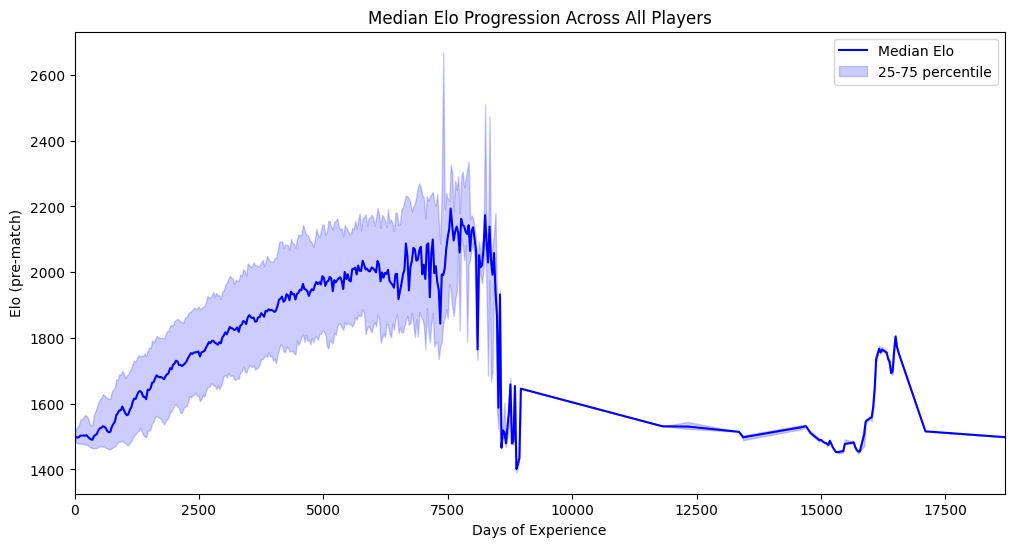

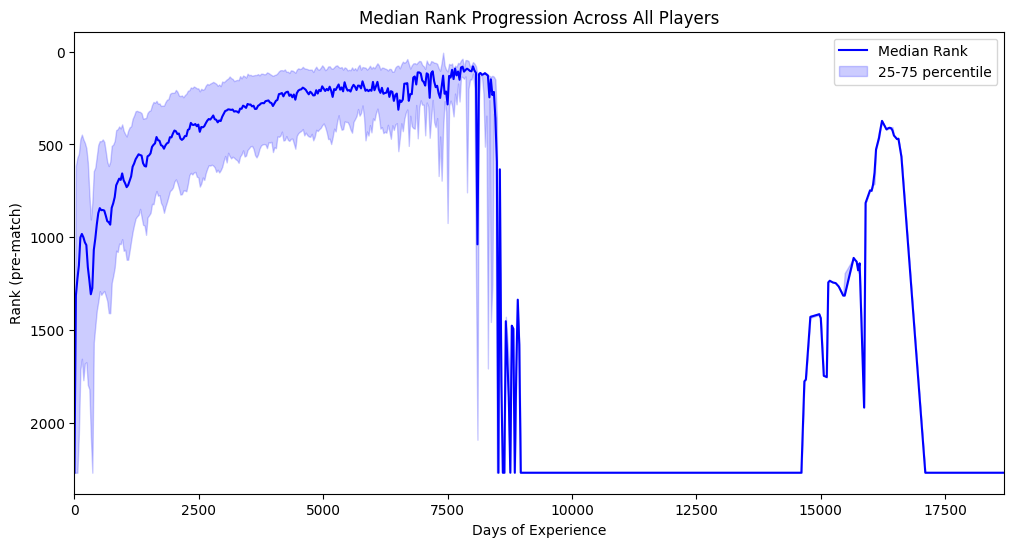

In [34]:
# ( vizualisation below. technically not needed in the pipeline )

# make a copy of the player_table to visualise
median_df = player_table_df.copy()

# Bin experience into 30-day intervals
median_df['days_bin'] = (median_df['days_of_experience'] // 30) * 30

# compute median Elo and rank per bin; calculate a median for every 30 days
median_curve = median_df.groupby('days_bin')['elo_pre_match'].median().reset_index(name='median_elo')

# compute 25th and 75th percentiles for shading to show how much variance there is between elo and player rank
q25_elo = median_df.groupby('days_bin')['elo_pre_match'].quantile(0.25).reset_index(name='q25_elo')
q75_elo = median_df.groupby('days_bin')['elo_pre_match'].quantile(0.75).reset_index(name='q75_elo')

# merge into one DataFrame
median_curve = median_curve.merge(q25_elo, on='days_bin').merge(q75_elo, on='days_bin')

plt.figure(figsize=(12,6))
plt.plot(median_curve['days_bin'], median_curve['median_elo'], color='blue', label='Median Elo')
plt.fill_between(median_curve['days_bin'], median_curve['q25_elo'], median_curve['q75_elo'], color='blue', alpha=0.2, label='25-75 percentile')
plt.xlabel('Days of Experience')
plt.ylabel('Elo (pre-match)')
plt.title('Median Elo Progression Across All Players')
plt.legend()
plt.margins(x=0)
#plt.show()

# do the same for player rank
median_rank = median_df.groupby('days_bin')['player_rank'].median().reset_index(name='median_rank')
q25_rank = median_df.groupby('days_bin')['player_rank'].quantile(0.25).reset_index(name='q25_rank')
q75_rank = median_df.groupby('days_bin')['player_rank'].quantile(0.75).reset_index(name='q75_rank')

median_curve = (
    median_rank
    .merge(q25_rank, on='days_bin')
    .merge(q75_rank, on='days_bin')
)

plt.figure(figsize=(12,6))
plt.plot(median_curve['days_bin'], median_curve['median_rank'], color='blue', label='Median Rank')
plt.fill_between(median_curve['days_bin'], median_curve['q25_rank'], median_curve['q75_rank'], color='blue', alpha=0.2, label='25-75 percentile')
plt.xlabel('Days of Experience')
plt.ylabel('Rank (pre-match)')
plt.title('Median Rank Progression Across All Players')
plt.legend()
plt.margins(x=0)
plt.gca().invert_yaxis()
#plt.show()